<a href="https://colab.research.google.com/github/minjeon99/ESAA_YB/blob/Week10/w10_mon_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **05. 회귀**

## **06 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**

### **규제 선형 모델의 개요**

- 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어해야 함
- RSS 최소화만 고려하면 학습 데이터에 과적합하여 회귀 계수가 쉽게 커짐
  - 변동성 심해져서 테스트 데이터에서 예측 성능 저하 우려

  => 비용함수는 RSS 최소화와 과적합 방지(회귀 계수 값이 커지지 않도록)가 균형을 이뤄야 함
- 비용 함수 목표 = Min(RSS(W) + alpha*||W||)
  - alpha: 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터

**alpha의 역할**
- alpha=0 -> 비용 함수 식이 기존과 동일
- alpha=무한대 -> W값을 0으로 만들어야 Cost가 최소화되는 비용 함수 목표 달성

  => alpha 값이 크면 비용 함수는 W 값을 작게 해 과적합을 개선,

    alpha 값이 작으면 W값이 커져도 상쇄 가능하므로 학습 데이터 적합을 개선
  
  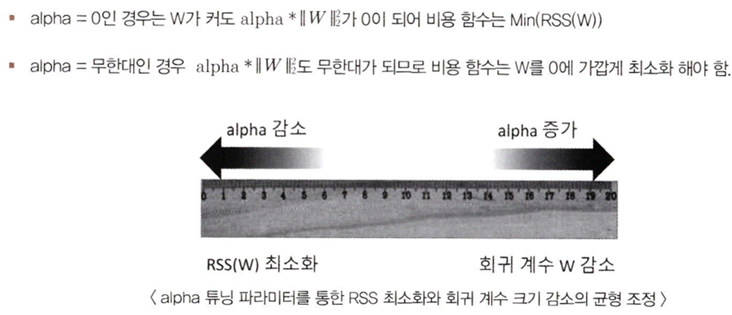

alpha를 0에서부터 지속적으로 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있음

**규제**: 비용함수에 alpha값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
- L2 규제: W 제곱에 대해 패널티를 부여하는 방식 = 릿지(Ridge) 회귀
  - alpha * $||W||_2^2$
- L1 규제: W의 절댓값에 대해 패널티를 부여하는 방식 = 라쏘(Lasso) 회귀
  - alpha * $||W||_1$
  - 영향력이 크지 않은 회귀 계수 값을 0으로 변환

### **릿지 회귀**

`Ridge` 클래스
- 주요 생성 파라미터: `alpha` = 릿지 회귀의 alpha L2 규제 계수


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

# feature name이 없으므로 따로 지정해줘야 함.

feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX' ,'PTRATIO', 'B' ,'LSTAT', 'PRICE']

bostonDF = pd.DataFrame(boston, columns=feature_names)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


- LinearRegression의 RMSE 평균(5.836)보다 뛰어난 예측 성능

alpha값을 0 , 0.1 , 1 , 10 , 100 으로 변경하면서 RMSE 측정

In [8]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


- alpha=100일 때 평균 RMSE 5.330으로 가장 좋음

각 alpha에 따른 회귀 계수 값을 시각화

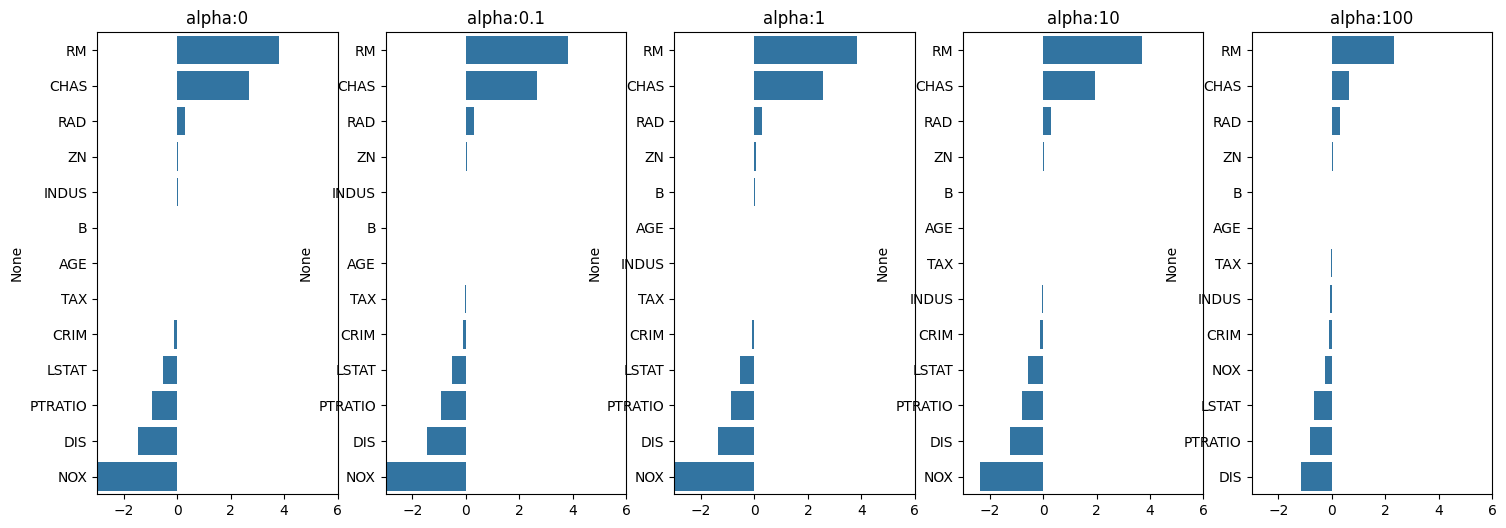

In [9]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

- alpha 값 증가시킬수록 회귀 계수 값 지속적으로 작아짐

alpha 값의 변화에 따른 릿지 회귀 계수 값

In [10]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### **라쏘 회귀**

- L2 규제가 회귀 계수의 크기를 감소시키는 데 반해 L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거
  - 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가짐

`Lasso` 클래스
- 주요 생성 파라미터: `alpha` = 라쏘 회귀의 alpha L1 규제 계수

In [11]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df
# end of get_linear_regre_eval

In [12]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


- alpha=0.07일 때 가장 좋은 평균 RMSE

alpha 값에 따른 피처별 회귀 계수

In [13]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


- alpha 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀜
  - NOX: 0.07일 때부터 회귀 계수 = 0
  - INDUS, CHAS: alpha 증가하면서 회귀 계수가 0으로 바뀜
- 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음

### **엘라스틱넷 회귀**

- L2 규제와 L1 규제를 결합한 회귀
- 비용함수 목표: RSS(W) + alpha2 * $||W||_2^2$ + alpha1 * $||W||_1$을 최소화하는 W를 찾는 것
- 라쏘 회귀: 서로 상관관계 높은 피처들의 경우 중요 피처만 셀렉션하고 다른 피처들의 회귀 계수를 모두 0으로 만드는 성향이 강함

  => alpha값에 따라 회귀 계수 값이 급격히 변동할 수도 있는데, 이를 완화하기 위해 L2 규제를 라쏘 회기에 추가한 것
- 상대적으로 수행시간이 상대적으로 오래 걸리는 단점

`ElasticNet` 클래스
- 주요 생성 파라미터: alpha, l1_ratio
  - alpha: (a + b)
    - 엘라스틱넷의 규제: a * L1 + b * L2
  - l1_ratio: a / (a + b)
    - l1_ratio=0이면 a=0이므로 L2 규제와 동일
    - l1_ratio=1이면 b=0이므로 L1 규제와 동일

In [14]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [15]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


- alpha=0.5일 때 평균 RMSE=5.467로 가장 좋은 예측 성능
- 라쏘보다는 상대적으로 alpha값에 따른 피처들의 회귀 계수 값이 0이 되는 값이 적음

### **선형 회귀 모델을 위한 데이터 변환**

- 선형 모델은 피처와 타깃값 간에 선형의 관계가 있다고 가정하고 최적의 선형 함수를 찾아내 결과값 예측
- 피처값과 타깃값의 분포=정규 분포 형태를 선호
  - 타깃값의 경우 정규 분포 형태가 아니라 왜곡(skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높음
  - 피처값도 결정값보다느 덜하지만 마찬가지

=> 선형 회귀 모델 적용 전 데이터에 대한 스케일링/정규화 작업 수행이 일반적
  - 무조건 예측 성능이 향상되는 것은 아님. 중요 피처/타깃값의 분포도가 심하게 왜곡됐을 경우 변환 작업 수행

**사이킷런을 이용한 변환 작업**
1. StandardScaler 클래스 => 평균=0, 분산=1인 표준 정규 분포를 가진 데이터 세트로 변환

  / MinMaxScaler 클래스를 이용해 최솟값=0, 최댓값=1인 값으로 정규화 수행
2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환. 1번 방법을 통한 예측 성능 향상이 없을 경우 적용
3. 원래 값에 log 함수를 적용하면 정규 분포에 가까운 형태로 값이 분포 = 로그 변환(Log Transformation)
  - 1,2번보다 훨씬 많이 사용되는 변환 방법
  - 1번: 예측 성능 향상 크게 기대하기 어려운 경우가 많음
  - 2번: 피처 개수가 많을 경우 다항 변환으로 생성되는 피처의 개수가 기하급수로 늘어가 과적합 이슈 발생 가능성

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree,
                                         include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [17]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]
#변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2),
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False, return_coeff=False)

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 
(506, 104) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMS

## **07 로지스틱 회귀**

로지스틱 회귀는 선형 회귀 방식을 **분류**에 적용한 알고리즘
- 분류에 사용
- 선형 회귀 계열 = 가중치 변수가 선형
- 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라

  시그모이드 함수 최적선을 찾고, 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류 결정

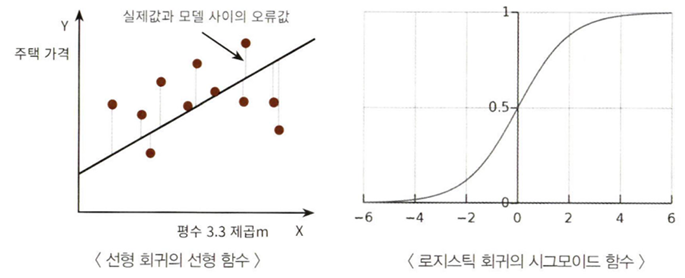

- 시그모이드 함수: $y=\frac{1}{1+e^{-x}}$
- x값에 관계없이 항상 0~1의 y값을 반환
  - x가 커질수록 1에 근사, x가 작아질수록 0에 근사
  - x=0일 때 y=0.5
- 선형 회귀선으로 잘 분류하지 못하는 데이터를 S자 커브 형태의 시그모이드 함수로 더 정확하게 분류 가능

  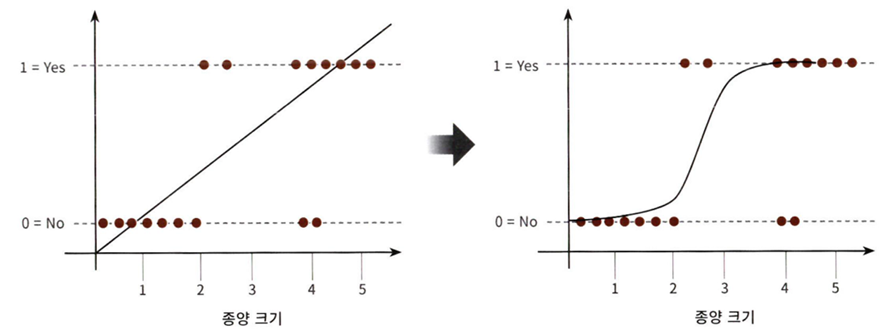

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression() # solver='lbfgs'
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds),
                                                 roc_auc_score(y_test , lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


`LogisticRegression` 클래스
- 주요 하이퍼 파라미터: penalty, C
  - penalty: 규제(Regularization)의 유형
    - l2(default): L2 규제, l1: L1 규제
  - C: 규제 강도를 조절하는 alpha 값의 역수 => C값이 작을수록 규제 강도 큼

In [21]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
# 여러개의 solver값 별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver,
                                                                  accuracy_score(y_test, lr_preds),
                                                                  roc_auc_score(y_test , lr_preds_proba)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.995
solver:liblinear, accuracy: 0.982, roc_auc:0.995
solver:newton-cg, accuracy: 0.977, roc_auc:0.995
solver:sag, accuracy: 0.982, roc_auc:0.995
solver:saga, accuracy: 0.982, roc_auc:0.995
